In [1]:
pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 70.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, MultiHeadAttention, Concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.model_selection import train_test_split
from underthesea import word_tokenize
from gensim.models import KeyedVectors
import tensorflow as tf
import time

2025-05-18 09:26:31.156440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747560391.394729      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747560391.466682      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# 1. Đọc và xử lý dữ liệu
data = pd.read_csv('/kaggle/input/hung-data-luat/augmented_only_dataset.csv')

data

,Câu hỏi tăng cường,Câu trả lời tăng cường
0,01012025 giấy hẹn giấy đăng_ký xe_máy tham_gia...,căn_cứ a_khoản 2 56 luật lệ trật_tự an_toàn gi...
1,01012025 giấy hẹn giấy đăng_ký xe_máy tham_gia...,căn_cứ a_khoản 2 56 luật trật_tự an_toàn giao_...
2,công_an xe_máy giấy 01012025 phạt giao_thông t...,lái_xe giấy giấy_tờ tham_gia 4 phù_hợp tham_gi...
3,01012025 giấy hẹn tham_gia giấy đăng_ký xe_máy...,căn_cứ a_khoản 2 56 luật trật_tự an_toàn giao_...
4,giấy đăng_ký xe_máy tham_gia giao_thông xử phạ...,căn_cứ khoản 2 17 nghị_định 100 2019 nđcp bổ_s...
...,...,...
52767,bồi_thường thiệt_hại hành_khách đi máy_bay thi...,căn_cứ 162 luật hàng_không dân_dụng việt_nam 2...
52768,tàu_biển thế_chấp vui_lòng giải_thích chi_tiết .,căn_cứ 38 bộ_luật hàng_hải việt_nam 2015 quy_đ...
52769,tàu_biển thế_chấp vui_lòng giải_thích chi_tiết .,căn_cứ 38 bộ_luật hàng_hải việt_nam 2015 quy_đ...
52770,giải_thích chi_tiết . thế_chấp vui_lòng tàu_biển,2015 a_nghĩa_vụ thế_chấp có_thể việt_nam quyền...


In [4]:
data.rename(columns={"Câu hỏi tăng cường": "question", "Câu trả lời tăng cường": "answer"}, inplace=True)

In [5]:
data

,question,answer
0,01012025 giấy hẹn giấy đăng_ký xe_máy tham_gia...,căn_cứ a_khoản 2 56 luật lệ trật_tự an_toàn gi...
1,01012025 giấy hẹn giấy đăng_ký xe_máy tham_gia...,căn_cứ a_khoản 2 56 luật trật_tự an_toàn giao_...
2,công_an xe_máy giấy 01012025 phạt giao_thông t...,lái_xe giấy giấy_tờ tham_gia 4 phù_hợp tham_gi...
3,01012025 giấy hẹn tham_gia giấy đăng_ký xe_máy...,căn_cứ a_khoản 2 56 luật trật_tự an_toàn giao_...
4,giấy đăng_ký xe_máy tham_gia giao_thông xử phạ...,căn_cứ khoản 2 17 nghị_định 100 2019 nđcp bổ_s...
...,...,...
52767,bồi_thường thiệt_hại hành_khách đi máy_bay thi...,căn_cứ 162 luật hàng_không dân_dụng việt_nam 2...
52768,tàu_biển thế_chấp vui_lòng giải_thích chi_tiết .,căn_cứ 38 bộ_luật hàng_hải việt_nam 2015 quy_đ...
52769,tàu_biển thế_chấp vui_lòng giải_thích chi_tiết .,căn_cứ 38 bộ_luật hàng_hải việt_nam 2015 quy_đ...
52770,giải_thích chi_tiết . thế_chấp vui_lòng tàu_biển,2015 a_nghĩa_vụ thế_chấp có_thể việt_nam quyền...


In [6]:
questions = data['question'].tolist()
answers = data['answer'].tolist()

In [7]:
# Chuẩn hóa dữ liệu: sửa lỗi từ ghép (thay dấu gạch dưới bằng khoảng cách)
questions = [q.replace('_', ' ') for q in questions]
answers = [a.replace('_', ' ') for a in answers]

In [8]:
# Token hóa văn bản bằng underthesea
questions = [word_tokenize(q, format='text') for q in questions]
answers = [word_tokenize(a, format='text') for a in answers]

# Thêm token <start> và <end>
questions = ['<start> ' + q + ' <end>' for q in questions]
answers = ['<start> ' + a + ' <end>' for a in answers]

In [9]:
# 2. Chia dữ liệu
train_questions, temp_questions, train_answers, temp_answers = train_test_split(
    questions, answers, test_size=0.2, random_state=42
)
val_questions, test_questions, val_answers, test_answers = train_test_split(
    temp_questions, temp_answers, test_size=0.5, random_state=42
)

print(f"Kích thước tập train: {len(train_questions)}")
print(f"Kích thước tập validation: {len(val_questions)}")
print(f"Kích thước tập test: {len(test_questions)}")

Kích thước tập train: 42217
Kích thước tập validation: 5277
Kích thước tập test: 5278


In [10]:
# 3. Token hóa
tokenizer = Tokenizer(filters='', num_words=10000)
tokenizer.fit_on_texts(train_questions + train_answers)
vocab_size = len(tokenizer.word_index) + 1
print(f"Kích thước từ vựng: {vocab_size}")

Kích thước từ vựng: 13971


In [11]:
# 4. Tạo ma trận embedding từ Word2Vec
word2vec_path = '/kaggle/input/hung-data-luat/baomoi.model_400.bin'
word2vec_model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
embedding_dim = 400  # Kích thước vector của baomoi.model_400.bin

# Tạo ma trận embedding
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= vocab_size:
        continue
    try:
        embedding_vector = word2vec_model[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        # Nếu từ không có trong Word2Vec, khởi tạo ngẫu nhiên
        embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), embedding_dim)

In [12]:
# 5. Chuyển văn bản thành chuỗi số
train_question_sequences = tokenizer.texts_to_sequences(train_questions)
train_answer_sequences = tokenizer.texts_to_sequences(train_answers)
val_question_sequences = tokenizer.texts_to_sequences(val_questions)
val_answer_sequences = tokenizer.texts_to_sequences(val_answers)
test_question_sequences = tokenizer.texts_to_sequences(test_questions)
test_answer_sequences = tokenizer.texts_to_sequences(test_answers)

In [13]:
# Đệm chuỗi
max_length = 50
train_question_padded = pad_sequences(train_question_sequences, maxlen=max_length, padding='post')
train_answer_padded = pad_sequences(train_answer_sequences, maxlen=max_length, padding='post')
val_question_padded = pad_sequences(val_question_sequences, maxlen=max_length, padding='post')
val_answer_padded = pad_sequences(val_answer_sequences, maxlen=max_length, padding='post')
test_question_padded = pad_sequences(test_question_sequences, maxlen=max_length, padding='post')
test_answer_padded = pad_sequences(test_answer_sequences, maxlen=max_length, padding='post')

In [14]:
# Chuẩn bị dữ liệu decoder (đồng bộ max_length)
decoder_input_data = train_answer_padded
decoder_target_data = np.zeros_like(decoder_input_data)
decoder_target_data[:, :-1] = decoder_input_data[:, 1:]  # Dịch phải 1 bước
decoder_target_data[:, -1] = 0  # Padding ở bước cuối

val_decoder_input_data = val_answer_padded
val_decoder_target_data = np.zeros_like(val_decoder_input_data)
val_decoder_target_data[:, :-1] = val_decoder_input_data[:, 1:]
val_decoder_target_data[:, -1] = 0

In [15]:
# 6. Xây dựng mô hình
lstm_units = 512

# Encoder
encoder_inputs = Input(shape=(max_length,))
encoder_embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, mask_zero=True)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, dropout=0.3)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_length,))
decoder_embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True, dropout=0.3)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

# Sử dụng MultiHeadAttention thay vì Attention
mha = MultiHeadAttention(num_heads=8, key_dim=lstm_units // 8)
attention_output = mha(query=decoder_outputs, value=encoder_outputs, key=encoder_outputs)
decoder_concat = Concatenate()([decoder_outputs, attention_output])
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat)

I0000 00:00:1747560596.952264      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [16]:
# Mô hình
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 7. Huấn luyện
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

history = model.fit(
    [train_question_padded, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),
    validation_data=([val_question_padded, val_decoder_input_data], np.expand_dims(val_decoder_target_data, -1)),
    batch_size=64,
    epochs=50,
    callbacks=[early_stopping, lr_scheduler]
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 400)        │      5,588,400 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 50)             │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 50, 400)        │      5,588,400 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 50, 512),      │      1,869,824 │ embedding[0][0],       │
│                           │ (None, 512), (None,    │                │ not_equal[0][0]        │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 50, 512),      │      1,869,824 │ embedding_1[0][0],     │
│                           │ (None, 512), (None,    │                │ lstm[0][1], lstm[0][2] │
│                           │ 512)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_1 (NotEqual)    │ (None, 50)             │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 50, 512)        │      1,050,624 │ lstm[0][0],            │
│ (MultiHeadAttention)      │                        │                │ not_equal[0][0],       │
│                           │                        │                │ lstm_1[0][0],          │
│                           │                        │                │ not_equal_1[0][0],     │
│                           │                        │                │ lstm[0][0],            │
│                           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 50, 1024)       │              0 │ lstm_1[0][0],          │
│                           │                        │                │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 50, 13971)      │     14,320,275 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 30,287,347 (115.54 MB)

 Trainable params: 19,110,547 (72.90 MB)

 Non-trainable params: 11,176,800 (42.64 MB)

Epoch 1/50


I0000 00:00:1747560606.796415     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


660/660 ━━━━━━━━━━━━━━━━━━━━ 101s 140ms/step - accuracy: 0.7434 - loss: 1.9623 - val_accuracy: 0.8102 - val_loss: 1.0594 - learning_rate: 0.0010
Epoch 2/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 91s 138ms/step - accuracy: 0.8168 - loss: 0.9881 - val_accuracy: 0.8290 - val_loss: 0.9197 - learning_rate: 0.0010
Epoch 3/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 91s 138ms/step - accuracy: 0.8367 - loss: 0.8278 - val_accuracy: 0.8388 - val_loss: 0.8634 - learning_rate: 0.0010
Epoch 4/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 91s 138ms/step - accuracy: 0.8488 - loss: 0.7379 - val_accuracy: 0.8453 - val_loss: 0.8330 - learning_rate: 0.0010
Epoch 5/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 91s 138ms/step - accuracy: 0.8597 - loss: 0.6685 - val_accuracy: 0.8500 - val_loss: 0.8182 - learning_rate: 0.0010
Epoch 6/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 91s 138ms/step - accuracy: 0.8687 - loss: 0.6130 - val_accuracy: 0.8540 - val_loss: 0.8055 - learning_rate: 0.0010
Epoch 7/50
660/660 ━━━━━━━━━━━━━━━━━━━━ 91s 138ms/step - accuracy: 0.8749 - loss

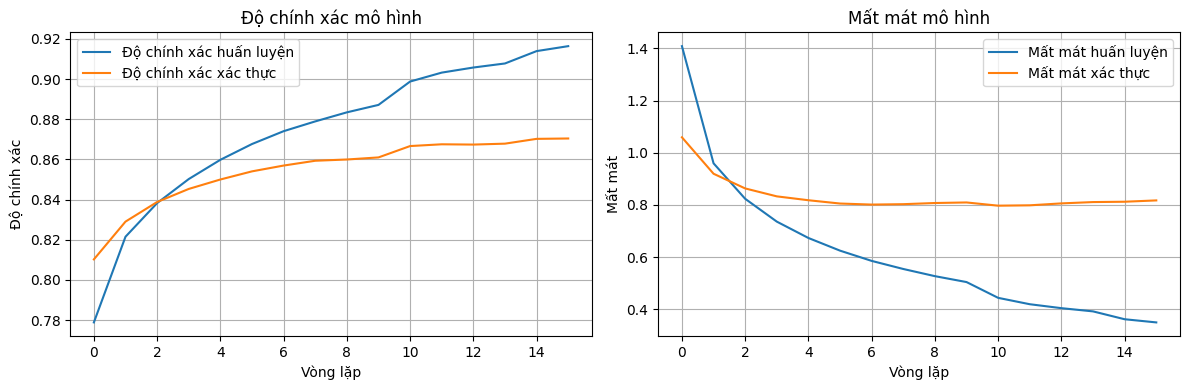

In [17]:
import matplotlib.pyplot as plt

# 8. Vẽ biểu đồ huấn luyện
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Độ chính xác huấn luyện')
plt.plot(history.history['val_accuracy'], label='Độ chính xác xác thực')
plt.title('Độ chính xác mô hình')
plt.xlabel('Vòng lặp')
plt.ylabel('Độ chính xác')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Mất mát huấn luyện')
plt.plot(history.history['val_loss'], label='Mất mát xác thực')
plt.title('Mất mát mô hình')
plt.xlabel('Vòng lặp')
plt.ylabel('Mất mát')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
# 8. Mô hình suy luận
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
decoder_encoder_outputs = Input(shape=(max_length, lstm_units))
decoder_inputs_single = Input(shape=(1,))
decoder_embedding_inf = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(decoder_inputs_single)
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(
    decoder_embedding_inf, initial_state=[decoder_state_input_h, decoder_state_input_c]
)
attention_output_inf = mha(query=decoder_outputs_inf, value=decoder_encoder_outputs, key=decoder_encoder_outputs)
decoder_concat_inf = Concatenate()([decoder_outputs_inf, attention_output_inf])
decoder_outputs_inf = decoder_dense(decoder_concat_inf)

decoder_model = Model(
    [decoder_inputs_single, decoder_state_input_h, decoder_state_input_c, decoder_encoder_outputs],
    [decoder_outputs_inf, state_h_inf, state_c_inf]
)

In [19]:
# 9. Hàm suy luận với Beam Search
def beam_search_decode(input_seq, beam_width=3, max_len=50):
    encoder_outputs, h, c = encoder_model.predict(input_seq, verbose=0)
    sequences = [[[], 0.0, [h, c]]]
    for _ in range(max_len):
        all_candidates = []
        for seq, score, states in sequences:
            if len(seq) > 0 and seq[-1] == tokenizer.word_index['<end>']:
                all_candidates.append([seq, score, states])
                continue
            target_seq = np.array([[seq[-1] if seq else tokenizer.word_index['<start>']]])
            output_tokens, h, c = decoder_model.predict(
                [target_seq, states[0], states[1], encoder_outputs], verbose=0
            )
            top_tokens = np.argsort(output_tokens[0, -1, :])[-beam_width:]
            for token in top_tokens:
                new_score = score + np.log(output_tokens[0, -1, token] + 1e-10)
                new_seq = seq + [token]
                all_candidates.append([new_seq, new_score, [h, c]])
        sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
    best_seq = sequences[0][0]
    return ' '.join([tokenizer.index_word.get(idx, 'UNK') for idx in best_seq if idx != 0])

In [20]:
# 10. Đánh giá
def evaluate_model(n_samples=5):
    for i in range(n_samples):
        input_seq = test_question_padded[i:i+1]
        question = test_questions[i]
        true_answer = test_answers[i]
        predicted_answer = beam_search_decode(input_seq)
        bleu_score = sentence_bleu([true_answer.split()], predicted_answer.split(), smoothing_function=SmoothingFunction().method1)
        print(f"Mẫu {i+1}:")
        print(f"Câu hỏi: {question}")
        print(f"Câu trả lời đúng: {true_answer}")
        print(f"Dự đoán: {predicted_answer}")
        print(f"BLEU score: {bleu_score:.4f}")
        print("-" * 50)

evaluate_model()

Mẫu 1:
Câu hỏi: <start> cá_nhân vi_phạm vi_phạm cố_tình quyết_định xử_phạt giao_thông xử_lý như_thế_nào <end>
Câu trả lời đúng: <start> căn_cứ 70 luật xử_lý vi_phạm hành_chính 2012 quy_định quyết_định xử_phạt 70 vi_phạm hành_chính giao ... <end>
Dự đoán: căn_cứ 70 luật xử_lý vi_phạm hành_chính 2012 quy_định quyết_định xử_phạt vi_phạm hành_chính lập biên_bản ... <end>
BLEU score: 0.6262
--------------------------------------------------
Mẫu 2:
Câu hỏi: <start> công_trình bảo_trì hàng_hải vui_lòng chi_phí . chi_tiết giải_thích <end>
Câu trả lời đúng: <start> . 1 chi_phí hàng_hải bảo_trì công_trình . bảo_trì 6 nghị_định xây_dựng kinh_phí tương_ứng thực_hiện ... <end>
Dự đoán: quy_định khoản 1 5 thông_tư 192022 ttbgtvt hiệu_lực 15012022 quy_định công_trình hạ_tầng kỹ_thuật ... <end>
BLEU score: 0.0291
--------------------------------------------------
Mẫu 3:
Câu hỏi: <start> phạt tham_gia ô_tô giao_thông lỗi bao_nhiêu lái_xe xe <end>
Câu trả lời đúng: <start> c tương_tự tương_tự a_khoản c 

In [21]:
import random
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics.pairwise import cosine_similarity

# Hàm tính vector biểu diễn câu
def get_sentence_embedding(sentence, word2vec_model, embedding_dim):
    words = sentence.split()
    vectors = []
    for word in words:
        if word in word2vec_model:
            vectors.append(word2vec_model[word])
    if not vectors:
        return np.zeros(embedding_dim)
    return np.mean(vectors, axis=0)

# Hàm beam_search_decode đã sửa lỗi cú pháp
def beam_search_decode(input_seq, beam_width=1, max_len=20):
    states_value = encoder_model.predict(input_seq, verbose=0)
    encoder_outputs, h, c = states_value
    sequences = [[[], 0.0, [h, c]]]
    for _ in range(max_len):
        all_candidates = []  # Sửa lỗi cú pháp từ "all candidates" thành "all_candidates"
        for seq, score, states in sequences:
            if len(seq) > 0 and seq[-1] == tokenizer.word_index['<end>']:
                all_candidates.append([seq, score, states])
                continue
            target_seq = np.array([[seq[-1] if seq else tokenizer.word_index['<start>']]])
            output_tokens, h_new, c_new = decoder_model.predict(
                [target_seq, states[0], states[1], encoder_outputs], verbose=0
            )
            top_tokens = np.argsort(output_tokens[0, -1, :])[-beam_width:]
            for token in top_tokens:
                new_score = score + np.log(output_tokens[0, -1, token] + 1e-10)
                new_seq = seq + [token]
                all_candidates.append([new_seq, new_score, [h_new, c_new]])
        sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]
    best_seq = sequences[0][0]
    return ' '.join([tokenizer.index_word.get(idx, 'UNK') for idx in best_seq if idx != 0])

def evaluate_model_extended(n_samples=5, full_test=False, subset_size=100):
    bleu_scores = []
    cosine_similarities = []
    
    if full_test:
        random.seed(42)  # Đảm bảo kết quả tái lập
        indices = random.sample(range(len(test_questions)), min(subset_size, len(test_questions)))
    else:
        indices = range(min(n_samples, len(test_questions)))
    
    samples_to_display = min(n_samples, len(indices))
    
    for i in indices:
        input_seq = test_question_padded[i:i+1]
        question = test_questions[i]
        true_answer = test_answers[i].replace('<start> ', '').replace(' <end>', '')
        predicted_answer = beam_search_decode(input_seq)
        
        # Tính BLEU score
        bleu_score = sentence_bleu(
            [true_answer.split()], 
            predicted_answer.split(), 
            smoothing_function=SmoothingFunction().method1
        )
        bleu_scores.append(bleu_score)
        
        # Tính Cosine Similarity
        true_embedding = get_sentence_embedding(true_answer, word2vec_model, embedding_dim)
        pred_embedding = get_sentence_embedding(predicted_answer, word2vec_model, embedding_dim)
        if np.any(true_embedding) and np.any(pred_embedding):
            cos_sim = cosine_similarity([true_embedding], [pred_embedding])[0][0]
        else:
            cos_sim = 0.0
        cosine_similarities.append(cos_sim)
        
        # Hiển thị chi tiết cho các mẫu được chọn
        if indices.index(i) < samples_to_display:  # Sửa để hiển thị đúng 5 mẫu đầu trong tập con
            print(f"Mẫu {indices.index(i)+1} (index {i}):")
            print(f"Câu hỏi: {question}")
            print(f"Câu trả lời đúng: {true_answer}")
            print(f"Dự đoán: {predicted_answer}")
            print(f"BLEU score: {bleu_score:.4f}")
            print(f"Cosine Similarity: {cos_sim:.4f}")
            print("-" * 50)
    
    # Tính trung bình
    avg_bleu = np.mean(bleu_scores)
    avg_cosine = np.mean(cosine_similarities)
    
    print("Kết quả tổng quát:")
    print(f"BLEU score trung bình trên tập test: {avg_bleu:.4f}")
    print(f"Cosine Similarity trung bình trên tập test: {avg_cosine:.4f}")

evaluate_model_extended(n_samples=3000, full_test=True, subset_size=3000)

Mẫu 1 (index 5238):
Câu hỏi: <start> mẫu đơn_mẫu đề_nghị giấy_phép lái_xe 2024 <end>
Câu trả lời đúng: đơn đề_nghị giấy_phép lái_xe 0162024 sử_dụng mẫu phụ_lục 17 ban_hành kèm thông_tư 052024 ttbgtvt . t ...
Dự đoán: căn_cứ phụ_lục 5 ban_hành kèm thông_tư 052024 ttbgtvt quy_định mẫu_đơn đề_nghị giấy_phép lái_xe ... <end>
BLEU score: 0.3045
Cosine Similarity: 0.8726
--------------------------------------------------
Mẫu 2 (index 912):
Câu hỏi: <start> nội_dung cao_tốc tài_chính dự_án m đường_bộ phương_án o <end>
Câu trả lời đúng: . cơ_sở xác_định nghị_định tính_toán bao_gồm quy_định 6 vốn thực_hiện thực_hiện cơ_chế căn_cứ thông ...
Dự đoán: quy_định 13 thông_tư 552023 ttbgtvt nội_dung khoản 1 . đối_với dự_án thực_hiện dự_án b ... <end>
BLEU score: 0.0174
Cosine Similarity: 0.7635
--------------------------------------------------
Mẫu 3 (index 204):
Câu hỏi: <start> công_trình hàng_không phục_vụ hoạt_động hàng_không công_trình <end>
Câu trả lời đúng: quy_định khoản 1 2 thông_tư ttbgtvt h